In [1]:
import illustris_python as il
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
#%matplotlib widget
basePath = './sims.TNG/TNG50-1/output'
from tqdm import tqdm
import gc
import os

In [3]:
Snapshot_Init = 71
Snapshot_End = 99
Lbsg_Indcies_Array = np.array([
    117251, 300903, 324123, 329508, 382215, 400973, 419618, 457431, 460722,
    490814
])

h = 0.6774  #km/Mpc

m_dm = 4.5E-5  #E10M_Sum
m_dm_h = m_dm * h

Critial_Density = 1.27E-8  #E10M_Sum/kpc^3
Critial_Density_h = Critial_Density / h**2  #E10M_Sum/(kpc/h)^3


In [4]:
def Cal_M_From_R_Phy(R_200_Float,Header_Dict):

    Omega_m=Header_Dict['Omega0']
    Omega_Lambda=Header_Dict['OmegaLambda']
    z=Header_Dict['Redshift']
    scale_factor=Header_Dict['Time']
    
    E_z=Omega_m*(1+z)**3+Omega_Lambda
    M_200_Float=200*Critial_Density_h*E_z*(R_200_Float**3)*4/3*3.14
    
    del Omega_m,Omega_Lambda,z,scale_factor,E_z
    
    return M_200_Float

def Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Particle_Coordinates_FloatArray,Particle_Masses_FloatArray):
    dist_to_com_floatarray = np.sqrt(np.sum((Particle_Coordinates_FloatArray - Galaxy_Center_FloatArray)**2, axis=1))
    within_radius_indices_intarray = np.where(dist_to_com_floatarray <= Mass_Radius_Float)[0]
    Total_Mass_Within_Radius_Float = np.sum(Particle_Masses_FloatArray[within_radius_indices_intarray])
    
    del dist_to_com_floatarray,within_radius_indices_intarray
    
    return Total_Mass_Within_Radius_Float

def DarkMatter_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Particle_Coordinates_FloatArray):
    dist_to_com_floatarray = np.sqrt(np.sum((Particle_Coordinates_FloatArray - Galaxy_Center_FloatArray)**2, axis=1))
    within_radius_indices_intarray = np.where(dist_to_com_floatarray <= Mass_Radius_Float)[0]
    Total_Mass_Within_Radius_Float = m_dm_h*within_radius_indices_intarray.shape[0]
    
    del dist_to_com_floatarray,within_radius_indices_intarray
    
    return Total_Mass_Within_Radius_Float

def Total_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Gas_Data_Dict,DarkMatter_Data_Dict,Stellar_Data_Dict,BlackHole_Data_Dict):
    
    darkmatter_mass_within_radius=DarkMatter_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,DarkMatter_Data_Dict)
    
    if len(Gas_Data_Dict)==1:gas_mass_within_radius=0
    else: gas_mass_within_radius=Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Gas_Data_Dict['Coordinates'],Gas_Data_Dict['Masses'])
    
    if len(Stellar_Data_Dict)==1:stellar_mass_within_radius=0
    else: stellar_mass_within_radius=Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,Stellar_Data_Dict['Coordinates'],Stellar_Data_Dict['Masses'])
    
    
    if len(BlackHole_Data_Dict)==1:blackholes_mass_within_radius=0
    else: blackholes_mass_within_radius=Baryon_Mass_Within_Given_Radius(Galaxy_Center_FloatArray,Mass_Radius_Float,BlackHole_Data_Dict['Coordinates'],BlackHole_Data_Dict['Masses'])
    
    Total_Mass_Within=gas_mass_within_radius+darkmatter_mass_within_radius+stellar_mass_within_radius+blackholes_mass_within_radius
    
    del gas_mass_within_radius,darkmatter_mass_within_radius,stellar_mass_within_radius,blackholes_mass_within_radius
    
    return Total_Mass_Within

def Cal_Subhalo_Id_at_Z_from_99(Subhalo_Id_0,Z):#Z is the snapshot
    subfindid_snapnum_tree=il.sublink.loadTree(basePath, 99, Subhalo_Id_0, fields=['SubfindID','SnapNum','Mass'], onlyMPB=True)
    
    if subfindid_snapnum_tree == None:return -1
    
    subfind_id=subfindid_snapnum_tree['SubfindID']
    snapshot_num=subfindid_snapnum_tree['SnapNum']
    index=np.where(snapshot_num==Z)[0]
    if index.shape[0] ==0:return -1
    return subfind_id[index][0]

def Velocity_Virial_Calculation(R_200,M_200):
    Unit=43007.1
    V=np.sqrt(M_200/R_200*Unit)
    return V

def Cal_Total_Spin(spin_array):
    len=0.0
    for axis_value in spin_array:
        len=len+axis_value**2
        
    return np.sqrt(len)

In [5]:
def R_200_Calculation(Snapshot_Num,Subhalo_Id):

    subhalo_data_dict=il.groupcat.loadSingle(basePath,Snapshot_Num,-1,Subhalo_Id)

    subhalo_comoving_position_floatarray=subhalo_data_dict['SubhaloPos']

    gas_data_dict=il.snapshot.loadSubhalo(basePath,Snapshot_Num,Subhalo_Id,'gas',fields=['Coordinates','Masses'])
    darkmatter_data_dict=il.snapshot.loadSubhalo(basePath,Snapshot_Num,Subhalo_Id,'darkmatter',fields=['Coordinates'])
    stellar_data_dict=il.snapshot.loadSubhalo(basePath,Snapshot_Num,Subhalo_Id,'stellar',fields=['Coordinates','Masses'])
    blackholes_data_dict=il.snapshot.loadSubhalo(basePath,Snapshot_Num,Subhalo_Id,'blackholes',fields=['Coordinates','Masses'])

    precision = 1
    max_iter = 100
    left, right = 0, 500

    header_dict=il.groupcat.loadHeader(basePath,Snapshot_Num)

    scale_factor=header_dict['Time']

    for i in range(max_iter):

        mid = (left + right) / 2

        mass_in_radius=Total_Mass_Within_Given_Radius(subhalo_comoving_position_floatarray,mid,gas_data_dict,darkmatter_data_dict,stellar_data_dict,blackholes_data_dict)

        mass_200=Cal_M_From_R_Phy(mid*scale_factor,header_dict)

        if mass_in_radius > mass_200:
            left = mid

        else:
            right = mid


        if abs(right - left) < precision or i == max_iter - 1:
            R_200_Com_Float = (left + right) / 2
            break

    R_200_Phy_Float=R_200_Com_Float*scale_factor

    M_200_Float=Cal_M_From_R_Phy(R_200_Phy_Float,header_dict)

    del subhalo_data_dict,subhalo_comoving_position_floatarray, gas_data_dict,darkmatter_data_dict,stellar_data_dict,blackholes_data_dict,precision,max_iter, left, right,header_dict,scale_factor,mid,mass_in_radius,mass_200

    gc.collect()
    return R_200_Phy_Float,M_200_Float

def Spin_Parameter_Calculation(Snapshot_Num,Subhalo_Id):
    

    header_dict=il.groupcat.loadHeader(basePath,Snapshot_Num)
    scale_factor=header_dict['Time']
    
    R_200, M_200 = R_200_Calculation(Snapshot_Num, Subhalo_Id)
    V_200 = Velocity_Virial_Calculation(R_200, M_200)

    subhalo_data_dict=il.groupcat.loadSingle(basePath,Snapshot_Num,-1,Subhalo_Id)
    
    total_spin=Cal_Total_Spin(subhalo_data_dict['SubhaloSpin'])

    Spin_Parameter=total_spin*scale_factor/(1.414*V_200*R_200)

    del R_200,M_200,header_dict,scale_factor,V_200,subhalo_data_dict,total_spin

    gc.collect()
    return Spin_Parameter

In [6]:
SP_Matrix=np.zeros(shape=(Snapshot_End+1-Snapshot_Init,Lbsg_Indcies_Array.shape[0]))

for current_snapshot in tqdm(range(Snapshot_Init,Snapshot_End+1)):

    for subhalo_id_0 in Lbsg_Indcies_Array:
        sub_index = np.where(Lbsg_Indcies_Array == subhalo_id_0)[0][0]
        subhalo_id = Cal_Subhalo_Id_at_Z_from_99(subhalo_id_0,
                                                 current_snapshot)

        if subhalo_id == -1: continue


        spin_parameter=Spin_Parameter_Calculation(current_snapshot,subhalo_id)

        SP_Matrix[abs(current_snapshot -
                      Snapshot_Init)][sub_index] = spin_parameter
np.save('./Lbsg_SP_Matrix.npy', SP_Matrix)


100%|██████████| 29/29 [54:25<00:00, 112.62s/it]


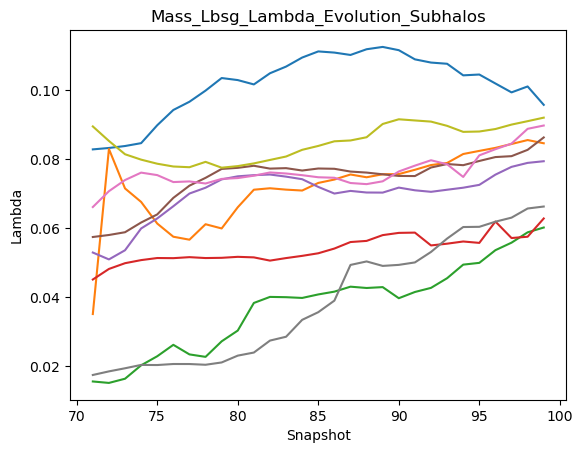

In [14]:
for i in range(len(Lbsg_Indcies_Array)):
    index=Lbsg_Indcies_Array[i]
    if index==460722:continue
    plt.plot(range(71,100),SP_Matrix[:,i])
    plt.xlabel('Snapshot')
    plt.ylabel('Lambda')
    plt.title(f'Mass_Lbsg_Lambda_Evolution_Subhalos')
